# Influenciadores ⚡

Análise e insights sobre influenciadores utilizando modelos de análise de sentimento e gráficos visualmente aprimorados.

## Importação de Bibliotecas 📚

Nesta seção, importamos as bibliotecas necessárias para análise.

In [2]:

# Importação de bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline

# Configuração global para gráficos
plt.style.use('ggplot')


## Carregamento de Dados 📥

Carregamos o arquivo CSV com os dados dos influenciadores.

In [3]:

# Carregar os dados
file_path = '/content/influenciadores.csv'
try:
    data = pd.read_csv(file_path)
    print(f"✅ Dados carregados com sucesso: {data.shape[0]} linhas e {data.shape[1]} colunas.")
except FileNotFoundError:
    print(f"❌ Arquivo não encontrado em {file_path}. Verifique o caminho.")


✅ Dados carregados com sucesso: 629 linhas e 7 colunas.


##  remover duplicados

In [4]:
# Remover duplicados com base na coluna 'Qual o @ (identifica a rede)'
data = data.drop_duplicates(subset=['Qual o @ (identifica a rede)'])

# Exibir o número de linhas restantes
print(f"Dados restantes após remoção de duplicados: {data.shape[0]} linhas.")

Dados restantes após remoção de duplicados: 549 linhas.


## Visualização de Dados 🔍

Examinamos os dados com gráficos iniciais para identificar tendências.

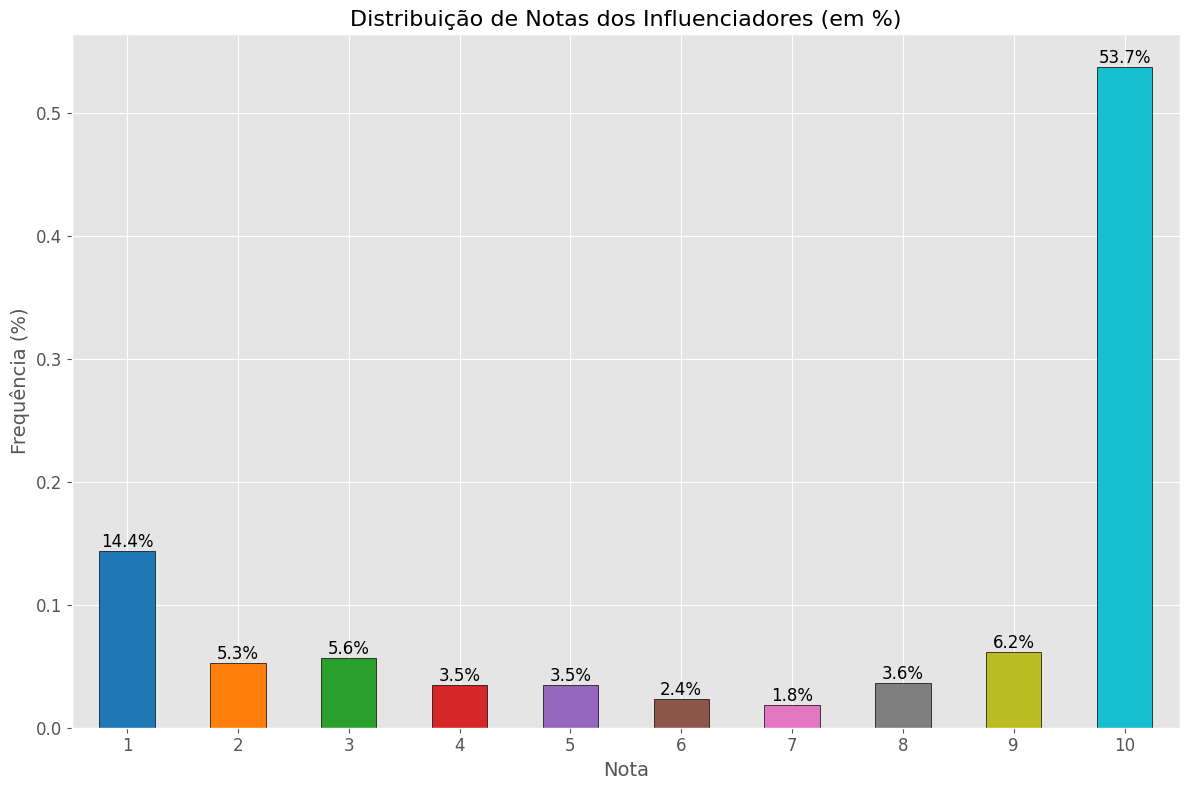

In [5]:
# Gráfico de barras: distribuição de notas dos influenciadores
plt.figure(figsize=(12, 8))

# Calculando distribuição percentual e ordenando
distribution = data['Qual a nota desse influ?'].value_counts(normalize=True).sort_index()

# Configurando cores para cada barra
colors = plt.cm.tab10(range(len(distribution)))

# Gerar o gráfico
distribution.plot(kind='bar', color=colors, edgecolor='black')

# Adicionar rótulos e título
plt.title('Distribuição de Notas dos Influenciadores (em %)', fontsize=16)
plt.xlabel('Nota', fontsize=14)
plt.ylabel('Frequência (%)', fontsize=14)

# Adicionar rótulos percentuais em cada barra
for index, value in enumerate(distribution):
    plt.text(index, value, f'{value*100:.1f}%', ha='center', va='bottom', fontsize=12)

plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


## Análise de Sentimento 💬

Utilizamos o modelo `bert-base-multilingual` para classificar sentimentos nos textos.

In [6]:

# Configurar análise de sentimento
sentiment_analyzer = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# Exemplo de análise
sample_text = "A colaboração foi um sucesso, muito muito boa!"
result = sentiment_analyzer(sample_text)
print(f"Texto: {sample_text}")
print(f"Sentimento: {result[0]['label']}, Confiança: {result[0]['score']:.2f}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


Texto: A colaboração foi um sucesso, muito muito boa!
Sentimento: 5 stars, Confiança: 0.67


Adicionar coluna sentiment_score com NLP 💬

In [38]:
from transformers import pipeline

# Configurar o pipeline de análise de sentimentos
sentiment_analyzer = pipeline("sentiment-analysis")

# Criar as colunas 'sentiment_score' e 'sentiment_confidence' com neutro
def analyze_sentiment_with_neutral(text):
    # Garantir que o texto seja string e truncar para evitar problemas com textos longos
    truncated_text = str(text)[:512]  # Limitar o texto a 512 caracteres
    result = sentiment_analyzer(truncated_text)[0]
    label = result['label']
    score = result['score']

    # Incluir a categoria neutra com base na confiança
    if score < 0.6:  # Threshold de confiança para considerar neutro
        sentiment_score = 0  # Neutro
    else:
        sentiment_score = 1 if label in ['POSITIVE', '5 stars'] else -1 if label in ['NEGATIVE', '1 star'] else 0
    return sentiment_score, score

# Garantir que os textos na coluna são strings
data['Como foi trabalhar com esse influ?'] = data['Como foi trabalhar com esse influ?'].fillna("Sem comentário").astype(str)

# Aplicar a análise de sentimento na coluna
data[['sentiment_score', 'sentiment_confidence']] = data['Como foi trabalhar com esse influ?'].apply(
    lambda x: pd.Series(analyze_sentiment_with_neutral(x))
)


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


In [39]:
test_texts = ["Foi ótimo trabalhar com este influenciador!", "Não gostei de trabalhar com este influenciador."]
for text in test_texts:
    result = sentiment_analyzer(text)
    print(f"Texto: {text}")
    print(f"Resultado do NLP: {result}")

Texto: Foi ótimo trabalhar com este influenciador!
Resultado do NLP: [{'label': 'POSITIVE', 'score': 0.9490427374839783}]
Texto: Não gostei de trabalhar com este influenciador.
Resultado do NLP: [{'label': 'NEGATIVE', 'score': 0.9778726100921631}]


# Contar avaliações positivas, negativas e neutras 📊

In [40]:
# Contar o número de avaliações positivas, negativas e neutras
if 'sentiment_score' in data.columns:
    # Contar a frequência de cada tipo de sentimento
    sentiment_counts = data['sentiment_score'].value_counts()

    # Calcular o total de sentimentos
    total_sentiments = sentiment_counts.sum()

    # Exibir as contagens e as porcentagens
    print("📈 Distribuição de Sentimentos:")
    print(f"✅ Positivas: {sentiment_counts.get(1, 0)} ({(sentiment_counts.get(1, 0) / total_sentiments * 100):.2f}%)")
    print(f"❌ Negativas: {sentiment_counts.get(-1, 0)} ({(sentiment_counts.get(-1, 0) / total_sentiments * 100):.2f}%)")
    print(f"⚖️  Neutras: {sentiment_counts.get(0, 0)} ({(sentiment_counts.get(0, 0) / total_sentiments * 100):.2f}%)")
else:
    print("⚠️ A coluna 'sentiment_score' não foi encontrada no dataset. Execute a célula anterior primeiro.")


📈 Distribuição de Sentimentos:
✅ Positivas: 29 (5.28%)
❌ Negativas: 505 (91.99%)
⚖️  Neutras: 15 (2.73%)


Comparar NLP com notas dos influenciadores ⭐

## Correlações e Insights 📊

Examinamos relações entre métricas importantes para identificar padrões.

📊 Comparação entre Notas e Sentimentos:

In [41]:
# Comparar notas numéricas com os sentimentos gerados pelo NLP
if 'sentiment_score' in data.columns and 'Qual a nota desse influ?' in data.columns:
    try:
        # Garantir que a coluna 'Qual a nota desse influ?' seja numérica
        data['Qual a nota desse influ?'] = pd.to_numeric(data['Qual a nota desse influ?'], errors='coerce')

        # Remover valores NaN gerados pela conversão
        valid_data = data.dropna(subset=['sentiment_score', 'Qual a nota desse influ?'])

        # Classificar notas em relação aos sentimentos
        positive_notes = valid_data[valid_data['sentiment_score'] > 0.5]['Qual a nota desse influ?']
        negative_notes = valid_data[valid_data['sentiment_score'] < 0.5]['Qual a nota desse influ?']

        # Calcular estatísticas
        avg_positive = positive_notes.mean() if not positive_notes.empty else None
        avg_negative = negative_notes.mean() if not negative_notes.empty else None

        print("📊 Comparação entre Notas e Sentimentos:")
        print(f"✅ Média das notas para comentários positivos: {avg_positive:.2f}" if avg_positive else "Nenhuma nota positiva disponível.")
        print(f"❌ Média das notas para comentários negativos: {avg_negative:.2f}" if avg_negative else "Nenhuma nota negativa disponível.")
    except Exception as e:
        print(f"❌ Erro durante a análise: {e}")
else:
    print("⚠️ Certifique-se de que as colunas 'sentiment_score' e 'Qual a nota desse influ?' existam no dataset.")


📊 Comparação entre Notas e Sentimentos:
✅ Média das notas para comentários positivos: 9.28
❌ Média das notas para comentários negativos: 7.11


⚓ Outliers

In [42]:
# Função para categorizar discrepâncias
def categorize_discrepancy(row):
    if row['sentiment_score'] < 0 and row['Qual a nota desse influ?'] >= 5:
        return "Alta nota, sentimento negativo"
    elif row['sentiment_score'] > 0 and row['Qual a nota desse influ?'] <= 3:
        return "Baixa nota, sentimento positivo"
    else:
        return "Consistente"

# Adicionar a categoria de discrepância
outliers['discrepancy_category'] = outliers.apply(categorize_discrepancy, axis=1)

# Selecionar as colunas relevantes para exibição
outliers_table = outliers[['Como foi trabalhar com esse influ?',
                           'Qual a nota desse influ?',
                           'sentiment_score',
                           'residual',
                           'discrepancy_category']]

# Exibir a tabela formatada diretamente no notebook
from IPython.display import display
print("📊 Discrepâncias Identificadas:")
display(outliers_table)


📊 Discrepâncias Identificadas:


<ipython-input-42-ceccdf14e94e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers['discrepancy_category'] = outliers.apply(categorize_discrepancy, axis=1)


,Como foi trabalhar com esse influ?,Qual a nota desse influ?,sentiment_score,residual,discrepancy_category
1,"Um caos, simplesmente impossível conseguir age...",4,-1,1.4,Consistente
3,terrível! ela não cumpre prazos e mente descar...,1,-1,1.1,Consistente
5,"Pressão mais baixa que a minha, era difícil en...",6,-1,1.6,"Alta nota, sentimento negativo"
6,"trabalhar com o igao foi bem estressante, pois...",5,-1,1.5,"Alta nota, sentimento negativo"
8,Terrível... Não trabalha com o que foi combina...,2,-1,1.2,Consistente
...,...,...,...,...,...
614,"Horrível. Só politicagem, promessas de engajam...",1,-1,1.1,Consistente
615,"PESSIMO! Primeiras entregas comecaram boas, ma...",1,-1,1.1,Consistente
622,A pior experiência de toda minha carreira. Tal...,1,-1,1.1,Consistente
623,"Nada profissional! Não segue briefing, não ent...",1,-1,1.1,Consistente


# Melhores e piores comentários

In [46]:
import pandas as pd

# Selecionar os melhores comentários
top_positive_comments = data[data['sentiment_score'] == 1].sort_values(
    by='sentiment_confidence', ascending=False).head(5)

# Selecionar os piores comentários
top_negative_comments = data[data['sentiment_score'] == -1].sort_values(
    by='sentiment_confidence', ascending=False).head(5)

# Criar tabelas
positive_table = top_positive_comments[['Como foi trabalhar com esse influ?', 'Qual a nota desse influ?', 'sentiment_confidence']].rename(
    columns={
        'Como foi trabalhar com esse influ?': 'Comentário',
        'Qual a nota desse influ?': 'Nota',
        'sentiment_confidence': 'Confiança do Sentimento'
    }
)

negative_table = top_negative_comments[['Como foi trabalhar com esse influ?', 'Qual a nota desse influ?', 'sentiment_confidence']].rename(
    columns={
        'Como foi trabalhar com esse influ?': 'Comentário',
        'Qual a nota desse influ?': 'Nota',
        'sentiment_confidence': 'Confiança do Sentimento'
    }
)

# Exibir tabelas
print("🟢 Tabela dos Melhores Comentários:")
positive_table


🟢 Tabela dos Melhores Comentários:


,Comentário,Nota,Confiança do Sentimento
33,"Se envolve na entrega, traz ideias, entrega ma...",10,0.999797
389,Excelente,10,0.999752
410,Bem ok…,5,0.995521
49,Show,10,0.994081
32,"Maravilhoso, super tranquilo, simpático, estud...",10,0.978614


In [47]:
print("\n🔴 Tabela dos Piores Comentários:")
negative_table


🔴 Tabela dos Piores Comentários:


,Comentário,Nota,Confiança do Sentimento
20,"MUITO enrolada, não cumpre os prazos... Deu um...",2,0.998936
102,UM CAOS!!! Não seguiu o briefing e nem o guide...,4,0.998908
277,"O Fred é muito bom de trabalhar junto, princip...",10,0.998505
85,HORRÍVEL. Horroroso! Fuja e corra bem rápido. ...,1,0.997701
217,"A Tata foi super simpática, mas ZERO criativid...",7,0.997383


## Conclusões ✨

Com base nas análises, destacamos os seguintes pontos:

1. Principais categorias mais representativas.
2. Tendências em sentimentos.
3. Relações entre métricas importantes.